In [1]:
from collections import ChainMap
import pandas as pd

from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style()
%matplotlib inline

In [2]:
result_file = 'timings.pickle' if False else 'timings_1.pickle'
timings = pd.read_pickle(result_file)

In [3]:
timings.groupby(['label', 'columns']).max()

block_count  elapsed_seconds  \
label                            columns                                 
Adjacent Blocking - 1 wildcard   1.0            108.0        21.759257   
                                 2.0          10821.0        28.027105   
                                 3.0          95606.0        13.030820   
                                 4.0          21543.0         9.850932   
                                 5.0           4641.0         8.207577   
                                 6.0           2154.0        14.745699   
                                 7.0            464.0        11.150917   
                                 8.0            215.0        18.459058   
                                 9.0             46.0        11.266297   
                                 10.0            21.0        14.731834   
Adjacent Blocking - 2 wildcards  2.0          10821.0        27.570006   
                                 3.0          95606.0        14.201808   
                                 4.0          21543.0        35.351580   
                                 5.0           4641.0        11.385280   
                                 6.0           1000.0        10.287565   
                                 7.0            464.0        18.867783   
                                 8.0            215.0        31.745558   
                                 9.0             46.0        12.803801   
                                 10.0            21.0        14.812764   
Adjacent Blocking - no wildcards 1.0            108.0        15.311595   
                                 2.0          10821.0        33.947001   
                                 3.0         195261.0        15.433767   
                                 4.0          46407.0        32.633097   
                                 5.0          21544.0        25.526414   
                                 6.0           4641.0        10.383963   
                                 7.0           1000.0         8.015980   
                                 8.0            464.0        11.334485   
                                 9.0            100.0        11.348308   
                                 10.0            21.0         9.467732   
Full                             1.0           2777.0         4.078338   
Sorted Neighbourhood             1.0              NaN        45.006894   
Standard Blocking                1.0            108.0        17.965429   
                                 2.0          11134.0        26.477483   
                                 3.0         650477.0        25.503617   
                                 4.0         995496.0        15.236583   
                                 5.0         999950.0        20.712583   
                                 6.0         999999.0       239.252824   
                                 7.0        1000000.0        12.756026   
                                 8.0        1000000.0        20.398191   
                                 9.0        1000000.0        11.738276   
                                 10.0       1000000.0        19.444928   

                                          est_length  granularity  \
label                            columns                            
Adjacent Blocking - 1 wildcard   1.0       6568074.0        100.0   
                                 2.0       8393580.0        100.0   
                                 3.0       5715009.0        100.0   
                                 4.0       5938353.0        100.0   
                                 5.0       2318781.0        100.0   
                                 6.0        785133.0        100.0   
                                 7.0        107416.0        100.0   
                                 8.0         23005.0        100.0   
                                 9.0          1035.0        100.0   
                                 10.0          210.0        100.0   
Adjacent Blocking - 2 wildcards

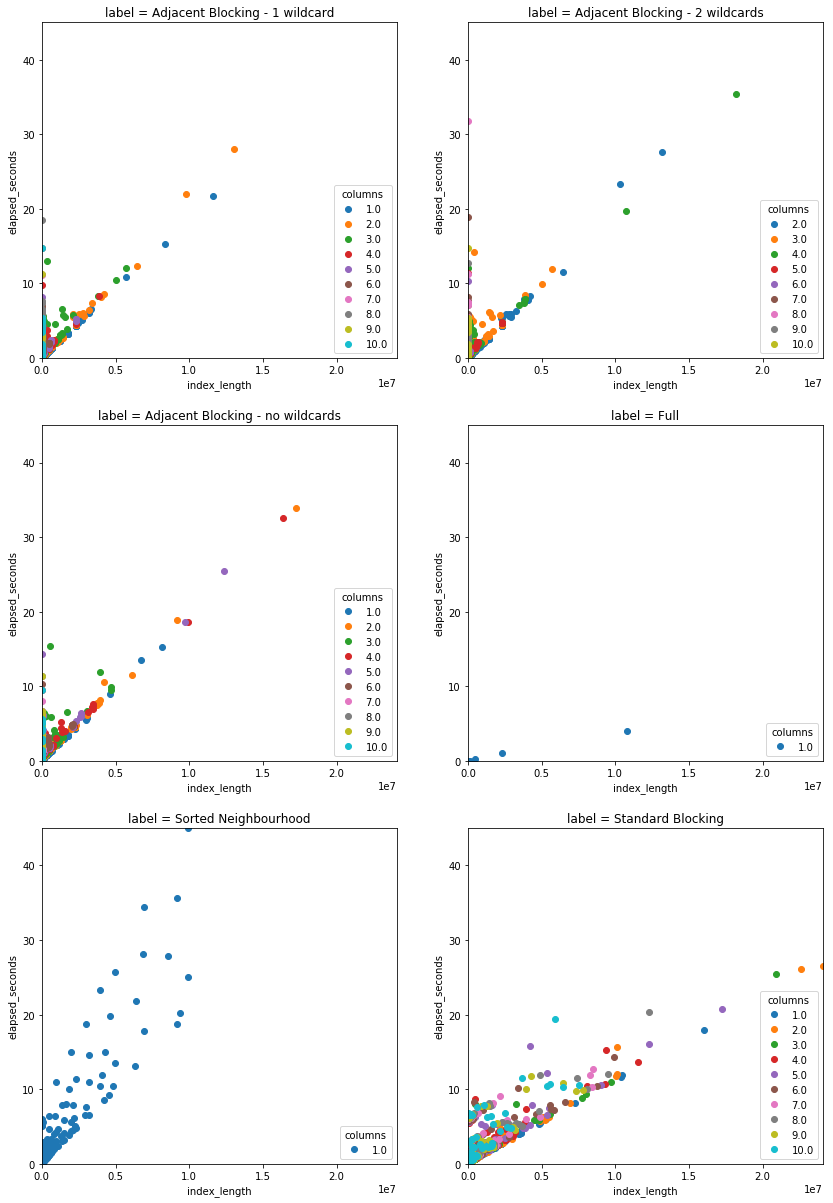

In [4]:
y_col = 'elapsed_seconds'
x_col = 'index_length'
label_col = 'columns'
graph_col = 'label'
max_cols = 2
filtered_timings = timings[timings['elapsed_seconds'] < 200]

graph_col_values = sorted(filtered_timings[graph_col].unique())
ncols = min([max_cols, len(graph_col_values)])
nrows = 1 + ((len(graph_col_values) - 1) // ncols)
xlim = (filtered_timings[x_col].min(), filtered_timings[x_col].max())
ylim = (filtered_timings[y_col].min(), filtered_timings[y_col].max())
fig, axs = plt.subplots(figsize=(7*ncols, 7*nrows), nrows=nrows, ncols=ncols)
for graph_col_value, ax in zip(graph_col_values, axs.flatten()):
    ax.set_title('{graph_col} = {graph_col_value}'.format(**locals()))
    ax.set_xlabel(x_col); ax.set_ylabel(y_col)
    ax.set_xlim(*xlim); ax.set_ylim(*ylim)
#    for axis, limits in [(ax.get_xaxis(), xlim), (ax.get_yaxis(), ylim)]:
#        if limits[1] - limits[0] > 100:
#            axis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
    graph_values = filtered_timings[filtered_timings[graph_col] == graph_col_value].sort_values(x_col)
    for label in sorted(graph_values[label_col].unique()):
        to_plot = graph_values[graph_values[label_col] == label]
        ax.plot(to_plot[x_col].values, to_plot[y_col].values, 'o', label=label)
    ax.legend(loc='lower right', title=label_col)
plt.show();

In [5]:
timings[(timings['max_nulls']==0) & (timings['columns']==1) & (timings['elapsed_seconds']>1)]#.groupby(['label', 'columns']).max()

,block_count,columns,elapsed_seconds,est_length,granularity,index_length,instances_per_entity,label,length_full,max_nulls,rows,reduction_ratio
90,106.0,1.0,2.971248,1.415094e+06,100.0,1446178.0,1.0,Adjacent Blocking - no wildcards,49995000.0,0.0,10000.0,0.971074
169,34.0,1.0,2.127188,9.502448e+05,31.0,993601.0,1.0,Adjacent Blocking - no wildcards,10767120.0,0.0,4641.0,0.907719
241,13.0,1.0,1.377654,5.353518e+05,10.0,639364.0,1.0,Adjacent Blocking - no wildcards,2318781.0,0.0,2154.0,0.724267
365,4.0,1.0,1.124371,3.750000e+05,1.0,486567.0,1.0,Adjacent Blocking - no wildcards,499500.0,0.0,1000.0,0.025892
1414,100.0,1.0,1.100749,3.230832e+05,100.0,429684.0,100.0,Adjacent Blocking - no wildcards,10767120.0,0.0,4641.0,0.960093
5473,34.0,1.0,2.091775,9.502440e+05,31.0,997371.0,3.0,Adjacent Blocking - no wildcards,10767120.0,0.0,4641.0,0.907369
5505,13.0,1.0,1.329434,5.353500e+05,10.0,637079.0,3.0,Adjacent Blocking - no wildcards,2318781.0,0.0,2154.0,0.725253
5565,4.0,1.0,1.119915,3.750000e+05,1.0,487551.0,3.0,Adjacent Blocking - no wildcards,499500.0,0.0,1000.0,0.023922
5667,13.0,1.0,1.383403,5.353500e+05,10.0,640619.0,10.0,Adjacent Blocking - no wildcards,2318781.0,0.0,2154.0,0.723726
5732,4.0,1.0,1.135716,3.750000e+05,1.0,489523.0,10.0,Adjacent Blocking - no wildcards,499500.0,0.0,1000.0,0.019974


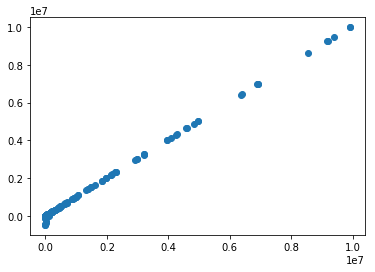

In [6]:
t2 = timings[timings['label'] == 'Sorted Neighbourhood']
plt.scatter(t2['index_length'].values, t2['est_length'].values)

In [7]:
label = 'Sorted Neighbourhood'
rows = 100000
columns = 1
granularity = 100
instances_per_entity = 2
comparison_rows = (timings['label'] == label) & (timings['rows'] <= rows) & (timings['columns'] == columns) & (timings['granularity'] >= granularity) & (timings['instances_per_entity'] <= instances_per_entity)
timings[comparison_rows].max()

block_count                             None
columns                                    1
elapsed_seconds                      5.11007
est_length                       2.29943e+06
granularity                            63095
index_length                     2.27503e+06
instances_per_entity                       1
label                   Sorted Neighbourhood
length_full                      4.99995e+09
max_nulls                               None
rows                                  100000
reduction_ratio                            1
dtype: object

In [8]:
t2.sort_values('index_length', ascending=False)

,block_count,columns,elapsed_seconds,est_length,granularity,index_length,instances_per_entity,label,length_full,max_nulls,rows,reduction_ratio
8307,NaN,1.0,45.006894,9999945.0,-10.0,9900355.0,1.0,Sorted Neighbourhood,4.999995e+11,NaN,1000000.0,0.999980
8315,NaN,1.0,24.999872,9994950.0,-100.0,9895050.0,1.0,Sorted Neighbourhood,4.999950e+09,NaN,100000.0,0.998021
8319,NaN,1.0,20.269161,9499500.0,-1000.0,9388500.0,1.0,Sorted Neighbourhood,4.999500e+07,NaN,10000.0,0.812211
8310,NaN,1.0,35.634015,9282950.0,-20.0,9191130.0,1.0,Sorted Neighbourhood,1.077211e+11,NaN,464158.0,0.999915
8316,NaN,1.0,18.754879,9262900.0,-200.0,9168100.0,1.0,Sorted Neighbourhood,1.077153e+09,NaN,46415.0,0.991489
8312,NaN,1.0,27.899937,8616900.0,-40.0,8531460.0,1.0,Sorted Neighbourhood,2.320774e+10,NaN,215443.0,0.999632
8305,NaN,1.0,34.405771,6999972.0,-7.0,6930259.0,1.0,Sorted Neighbourhood,4.999995e+11,NaN,1000000.0,0.999986
8314,NaN,1.0,17.833889,6997515.0,-70.0,6927585.0,1.0,Sorted Neighbourhood,4.999950e+09,NaN,100000.0,0.998614
8308,NaN,1.0,28.198929,6962250.0,-15.0,6893385.0,1.0,Sorted Neighbourhood,1.077211e+11,NaN,464158.0,0.999936
8311,NaN,1.0,21.814074,6462825.0,-30.0,6398745.0,1.0,Sorted Neighbourhood,2.320774e+10,NaN,215443.0,0.999724
